In [1]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import optimizers
import keras
# from keras.applications.xception import Xception
# from keras.applications.resnet50 import ResNet50
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet121
import cv2
import os
import seaborn as sns
# from keras.preprocessing.image import load_img, img_to_array


import warnings
warnings.filterwarnings('ignore')

def display_image(image, title=''):
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Using TensorFlow backend.


# load data

In [2]:
#vgg can't take input of 28x28 so we shall resize all our images
pickle_folder = "pickle files"
input_shape=(84, 84, 1)
data = pickle.load(open('data.pickle', 'rb'))
print("Data of format:")
for ch in data:
    print("data_length(" + ch + ") =", len(data[ch]))

#no. of classes
classes = len(data.keys())

Data of format:
data_length(त्र) = 205
data_length(प) = 205
data_length(ग) = 205
data_length(र) = 205
data_length(ठ) = 205
data_length(ह) = 205
data_length(क्ष) = 205
data_length(ए) = 221
data_length(भ) = 205
data_length(झ) = 205
data_length(छ) = 205
data_length(घ) = 205
data_length(श) = 205
data_length(न) = 205
data_length(उ) = 221
data_length(द) = 205
data_length(स) = 205
data_length(ण) = 205
data_length(ञ) = 205
data_length(ज्ञ) = 205
data_length(ल) = 205
data_length(व) = 205
data_length(ट) = 205
data_length(ड) = 205
data_length(ब) = 205
data_length(त) = 205
data_length(ध) = 205
data_length(इ) = 221
data_length(ख) = 205
data_length(य) = 205
data_length(फ) = 205
data_length(थ) = 205
data_length(क) = 205
data_length(ङ) = 205
data_length(म) = 205
data_length(अ) = 221
data_length(च) = 205
data_length(ऊ) = 221
data_length(ष) = 205
data_length(ढ) = 205
data_length(ज) = 205


# Rearranging data in input-output format

In [3]:
file = "class_numerals_{}.pickle".format(classes)
if file in os.listdir(pickle_folder):
    class_numerals = pickle.load(open(os.path.join(pickle_folder, file), 'rb'))
    print("Unpickled")
else:
    class_numerals = {i:list(data.keys())[i] for i in range(classes)}
    pickle.dump(class_numerals, open(os.path.join(pickle_folder, file), 'wb'))
    print("Error. Incompatible. Pickled new file:", file)
def character_to_encoding(char, classes=classes):
    for i in class_numerals:
        if class_numerals[i] == char:
            return np_utils.to_categorical(i, classes)

def encoding_to_character(encoding):
    return class_numerals[encoding.argmax()]

Unpickled


In [4]:
X = []
y = []

for ch in data:
    X += data[ch]
    y += [ch] * len(data[ch])
    
#resizing input image and preprocessin
X = np.array(list(map(lambda x: cv2.resize(x/255, (input_shape[0], input_shape[1])).reshape((input_shape[0], input_shape[1], 1)), X)))
y_ = np.array(list(map(lambda x: character_to_encoding(x, classes), y)))

print(X.shape, y_.shape)

(8485, 84, 84, 1) (8485, 41)


# Train-Test split

In [5]:
train_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y_, train_size=0.8, random_state=20, shuffle=True, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6788, 84, 84, 1), (6788, 41), (1697, 84, 84, 1), (1697, 41))

# CNN

In [6]:
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


print("GPUs:", k.tensorflow_backend._get_available_gpus())

print("input shape:", input_shape)
print("classes:", classes)

def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

GPUs: ['/job:localhost/replica:0/task:0/device:GPU:0']
input shape: (84, 84, 1)
classes: 41


creating the model below

In [15]:
%%time

batch_size = 32
num_classes = classes
epochs = 500
k_r = 0.01
b_r = 0.01
dropout = 0.5

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=0, mode='auto')

model = Sequential()
#conv layer 
model.add(Conv2D(32, kernel_size=(9, 9),
                 activation='relu',
                  kernel_initializer='he_normal',
                  kernel_regularizer=keras.regularizers.l2(k_r),
                  bias_regularizer=keras.regularizers.l2(b_r),
                 input_shape=input_shape))
model.add(MaxPooling2D((3, 3)))
# model.add(Dropout(dropout))
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='sigmoid',
                  kernel_initializer='he_normal',
                  kernel_regularizer=keras.regularizers.l2(0.1),
                  bias_regularizer=keras.regularizers.l2(0.05)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(dropout))

# model.add(Conv2D(64, kernel_size=(3, 3),
#                  activation='relu',
#                   kernel_initializer='he_normal',
#                   kernel_regularizer=keras.regularizers.l2(k_r),
#                   bias_regularizer=keras.regularizers.l2(b_r)))
# model.add(Conv2D(64, kernel_size=(3, 3),
#                  activation='relu',
#                   kernel_initializer='he_normal',
#                   kernel_regularizer=keras.regularizers.l2(k_r),
#                   bias_regularizer=keras.regularizers.l2(b_r)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(dropout))

# model.add(Conv2D(128, kernel_size=(3, 3),
#                  activation='relu',
#                   kernel_initializer='he_normal',
#                   kernel_regularizer=keras.regularizers.l2(k_r),
#                   bias_regularizer=keras.regularizers.l2(b_r)))
# model.add(Conv2D(128, kernel_size=(3, 3),
#                  activation='relu',
#                   kernel_initializer='he_normal',
#                   kernel_regularizer=keras.regularizers.l2(k_r),
#                   bias_regularizer=keras.regularizers.l2(b_r)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(dropout))

# NN
model.add(Flatten())
#hidden layer 1
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.05))
#hidden layer 2
model.add(Dense(768, activation='relu', kernel_regularizer=keras.regularizers.l2(k_r)))
model.add(Dropout(dropout))
#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
print("\n############################")
print("## Memory usage:", get_model_memory_usage(batch_size=batch_size, model=model), "GB ##")
print("############################\n")

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.15,
        callbacks = [early_stopping_callback])
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 76, 76, 32)        2624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 768)               5948160   
__________

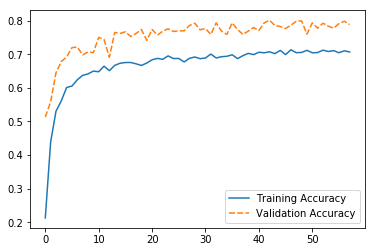

In [9]:
dicty = {
    'Training Accuracy': history.history['acc'],
    'Validation Accuracy': history.history['val_acc'],
}
sns.lineplot(data=pd.DataFrame(dicty))

In [12]:
original_model = model
# model = keras.models.load_model(os.path.join(pickle_folder, "RandomCNN_च_76.h5"))

model = original_model

predictions = model.predict(X_test)

for row in range(len(predictions)):
    predictions[row][predictions[row].argmax()] = 1
    predictions[row][predictions[row] != 1] = 0

false_array = np.all((predictions==y_test), axis=1)
num_wrong = (~false_array).sum()
print("Wrong predictions:", num_wrong, '/', y_test.shape[0], 1-num_wrong/y_test.shape[0])
wrong_walas_1 = pd.Series(list(map(encoding_to_character, predictions[~false_array]))).value_counts()
print(wrong_walas_1)


predictions = model.predict(X_train)

for row in range(len(predictions)):
    predictions[row][predictions[row].argmax()] = 1
    predictions[row][predictions[row] != 1] = 0

false_array = np.all((predictions==y_train), axis=1)
num_wrong = (~false_array).sum()
print("Wrong predictions:", num_wrong, '/', y_train.shape[0], 1-num_wrong/y_train.shape[0])
wrong_walas_2 = pd.Series(list(map(encoding_to_character, predictions[~false_array]))).value_counts()
print(wrong_walas_2)

Wrong predictions: 369 / 1697 0.7825574543311726
ऊ      30
ञ      28
ध      26
थ      18
ढ      17
व      16
ज      15
ल      14
छ      13
ज्ञ    13
स      12
त      12
य      11
ड      10
प      10
च       9
झ       8
न       8
म       7
उ       7
ट       7
श       6
र       6
ण       6
इ       5
फ       5
ठ       5
ए       5
भ       4
द       4
ङ       4
क       4
क्ष     4
ब       4
घ       4
अ       3
त्र     3
ग       2
ह       2
ष       2
dtype: int64
Wrong predictions: 938 / 6788 0.8618149675898645
ढ      57
ञ      56
ऊ      55
व      52
ध      48
ड      41
ज      38
स      37
छ      35
थ      35
ल      34
झ      32
ज्ञ    30
य      28
न      26
इ      26
ट      22
घ      21
म      21
च      20
प      18
त      16
भ      16
त्र    15
द      14
ब      14
क्ष    14
ङ      13
श      13
ठ      12
उ      12
ण      11
ष       9
क       8
अ       8
फ       8
ए       7
ग       6
र       5
ह       3
ख       2
dtype: int64


count = 10
a = ~false_array
for i in range(len(a)):
    if a[i]:
        count -= 1
        print(count, encoding_to_character(predictions[i]), encoding_to_character(y_test[i]))
        display_image(X_test[i])
        if count <= 0:
            break

In [14]:
file_name = "RandomCNN_"+str(wrong_walas_1.argmax())+'_'+str(wrong_walas_1[0])
if file_name + '.h5' not in os.listdir(pickle_folder):
    save_model(model, os.path.join(pickle_folder, file_name + '.h5'))
    f = open(os.path.join(pickle_folder, file_name + '.txt'), 'w')
    f.write(str(wrong_walas_1))
    f.write("\n\n")
    f.write(str(wrong_walas_2))
    f.close()